# Examining Pipeline Outputs

This notebook demonstrated the parsing of output data from the `snat_sim` pipeline.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy.stats.stats import pearsonr


## Parsing Data

Results from the analysis pipeline are written to disk over multiple files. We read data from each file and concatenate the results. 

Values that are not fit for are masked using the value `-99.99`. For conveniance, we replace these values with `nan` in the below example. 

For a full overview of the output file data model, see the [data model documentation](https://lsstdesc.org/SN-PWV/overview/data_model.html).


In [2]:
def get_combined_data_table(directory, key):
    """Return a single data table from directory of HDF5 files
    
    Returns concatenated tables from each of the files.
    
    Args:
        directory (Path): The directory to parse data files from
        key        (str): Key of the table in the HDF5 files
        
    Returns:
        A pandas datafram with pipeline data
    """

    
    if not (h5_files := list(directory.glob('*.h5'))):
        raise ValueError('No h5 files found in given directory')
    
    dataframes = []    
    for file in h5_files:
        with pd.HDFStore(file, 'r') as datastore:
            dataframes.append(datastore.get(key))
            
    return pd.concat(dataframes).set_index('snid')


def load_pipeline_data(directory, add_derived_values=False):
    """Return the combined input and output parameters from a pipeline run
    
    Args:
        directory          (Path): The directory to parse data files from
        add_derived_values (bool): Add in extra values derived from pipeline results
        
    Returns:
        A pandas datafram with pipeline data
    """
    
    sim_params = get_combined_data_table(directory, '/simulation/params')
    fit_results = get_combined_data_table(directory, '/fitting/params')

    # Combine the imput simulation parameters and the fit results into a single dataframe
    # The keys in ``fit_results`` are expected to be a proper subset of ``sim_params``
    # so we left join on ``fit_results``
    pipeline_data = fit_results.join(sim_params)

    # Join results for failed fit results will be nan.
    return pipeline_data.replace(-99.99, np.nan)


In [3]:
def add_derived_values(pipeline_data):
    """Calculate some useful values and add them to a dataframe of pipeline data
    
    Args:
        pipeline_data (DataFrame): Pipeline data returned by ``load_pipeline_data``
        
    Returns:
        A copy of the given dataframe with added columns
    """
    
    pipeline_data = pipeline_data.copy()
    for param in ('z', 't0', 'x0', 'x1', 'c'):
        pipeline_data[f'delta_{param}'] = pipeline_data[f'fit_{param}'] - pipeline_data[param]
        pipeline_data[f'delta_{param}_norm'] = pipeline_data[f'delta_{param}'] / pipeline_data[f'{param}']
    
    return pipeline_data


In [4]:
dir_4 = Path.home() / 'Downloads' / 'pwv_sim_epoch_fit_4'
sim_epoch_fit_4 = add_derived_values(load_pipeline_data(dir_4))


## Accuracy of Fitted Parameters


In [5]:
def plot_parameter_accuracy(
    data, 
    params=('t0', 'x0', 'x1', 'c'),
    bins=np.linspace(-1, 1, 200),
    figsize=(20, 5)
):
    """Plot histograms of the normalized difference between 
    simulated and fitted model parameters.
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        bins     (Array): Bins to use when building histograms
        figsize  (tuple): Size of the generated figure
    """
    
    fig, axes = plt.subplots(1, len(params), figsize=figsize)
    for param, axis in zip(params, axes):
        xmin = min(bins)
        xmax = max(bins)
        
        axis_data = data[f'delta_{param}_norm']
        axis_data = axis_data[xmin <= axis_data][axis_data <= xmax]
        median = axis_data.median()
        mean = axis_data.mean()
        std = axis_data.std()
        print('Standard Deviation for', param, '::', std)
        
        hist = axis.hist(axis_data, bins=bins)
        axis.axvline(median, linestyle='--', color='k', label=f'Median: {median:.2f}')
        
        axis.set_xlabel(r'$\frac{' + param + r'_{sim} - ' + param + '_{fit}}{' + param + '_{sim}}$', fontsize=16)
        axis.set_xlim(xmin, xmax)
        axis.set_title(param)
        axis.legend()


Standard Deviation for t0 :: 0.0
Standard Deviation for x0 :: 0.15935256278401003
Standard Deviation for x1 :: 0.329576210017005
Standard Deviation for c :: 0.39139226508740843


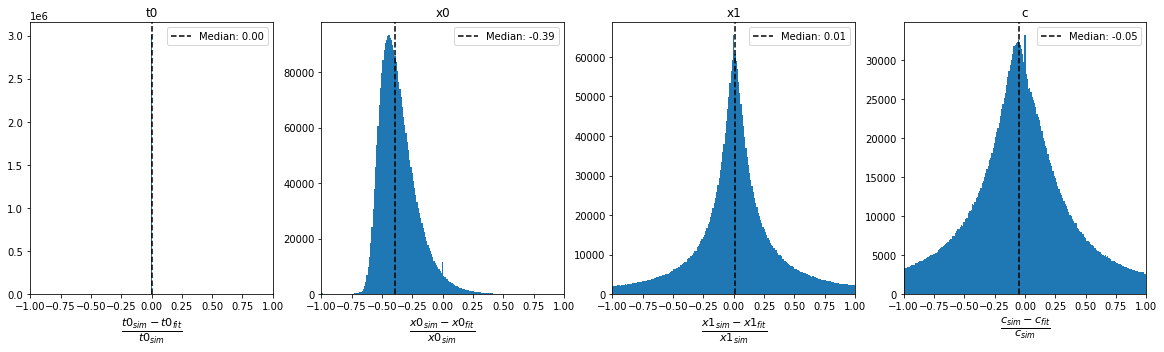

In [6]:
plot_parameter_accuracy(sim_epoch_fit_4)


In [7]:
def density_plot(
    data, 
    params=('t0', 'x0', 'x1', 'c'),
    x_val='z',
    figsize=(20, 5),
    bins=50,
    cmap='Blues'
):
    """Plot 2d histogram of the normalized difference between 
    simulated and fitted model parameters relative to a given 
    dataframe column.
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        params   (tuple): Tuple of parameter names to plot distributions for
        x_val      (str): Name of column to use for the x axis
        figsize  (tuple): Size of the generated figure
        bins       (int): Number of bins to use in the histogram
        cmap       (str): Name of the color map to use
    """
    
    fig, axes = plt.subplots(1, len(params), figsize=figsize)
    for param, axis in zip(params, axes):
        data = data[data[f'delta_{param}_norm'].abs() <= 1]
        y_data = data[f'delta_{param}_norm']
        x_data = data[x_val]
        
        axis.hist2d(x_data, y_data, bins=bins, cmap=cmap)
        axis.set_xlabel(x_val, fontsize=16)
        axis.set_ylabel(param, fontsize=16)
        axis.set_ylim(-1, 1)
            
    plt.tight_layout()
    

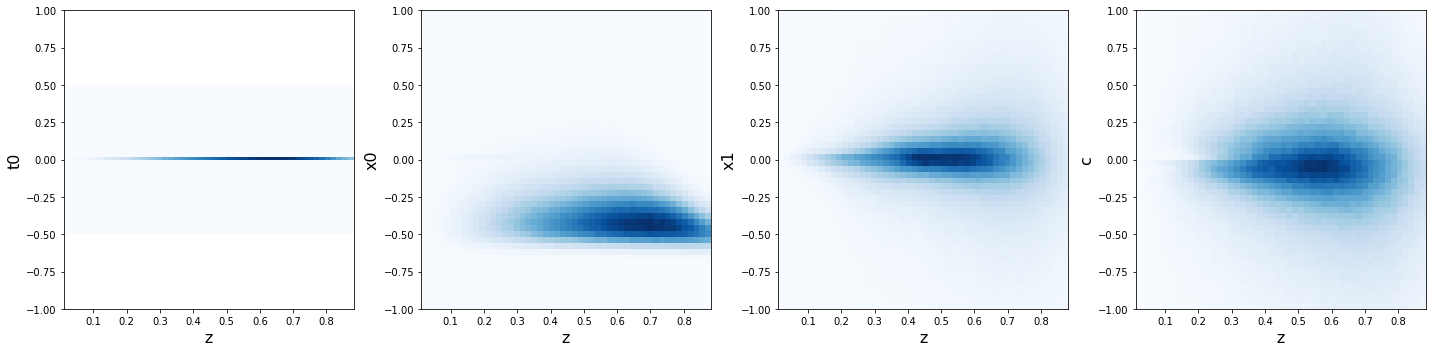

In [8]:
density_plot(sim_epoch_fit_4)


In [9]:
def plot_ra_dec(data, param, cmap='bwr'):
    """Plot normalized residuals on a sky map
    
    Args:
        data (DataFrame): Pipeline data to use for the plot
        param      (str): Name of the parameter to plot accuracy for
        cmap       (str): Name of the color map to use
    """
    
    resid = data[f'delta_{param}_norm']
    median_resid = resid.median()
    sn_coord = SkyCoord(data['ra'], data['dec'], unit=u.deg).galactic
    
    plt.figure(figsize=(10, 5))
    plt.subplot(111, projection='aitoff')
    plt.grid(True)

    scat = plt.scatter(
        sn_coord.l.wrap_at('180d').radian, 
        sn_coord.b.radian, c=resid, 
        vmin=-1 + median_resid, 
        vmax=1 + median_resid, 
        s=1, 
        cmap=cmap)
    
    plt.colorbar(scat).set_label(f'Accuracy in {param} (Median = {median_resid:.2f})', rotation=270, labelpad=15)


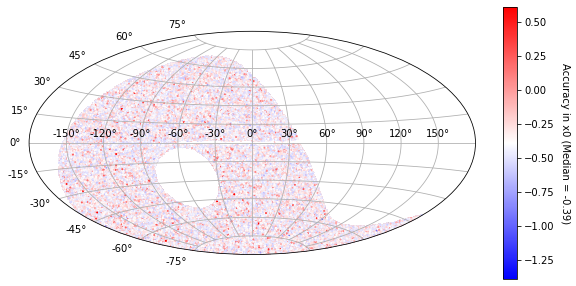

In [10]:
plot_ra_dec(sim_epoch_fit_4, 'x0')


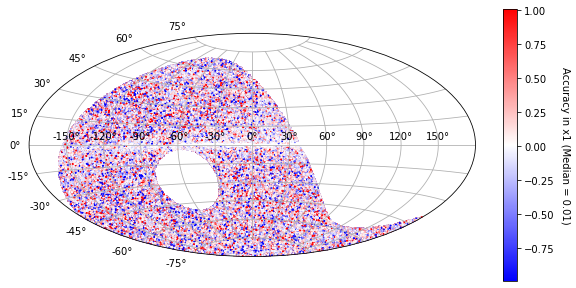

In [11]:
plot_ra_dec(sim_epoch_fit_4, 'x1')


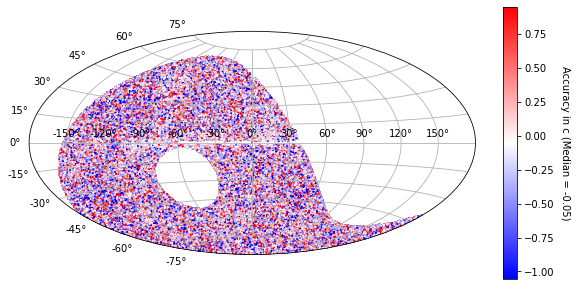

In [12]:
plot_ra_dec(sim_epoch_fit_4, 'c')


## Correlation Between Residuals and SN Properties

In [13]:
def calc_correlations(
    data,
    params=('t0', 'x0', 'x1', 'c'),
    properties=('z', 'ra', 'dec')
):
    """Calculate the pearson correlation coefficiant between the
    accuracy in fitted parameters and SN properties
    
    Args:
        data   (DataFrame): Pipeline data to use for the plot
        params     (tuple): Model parameters to calculate covariance for
        properties (tuple): Name of SN properties to calculate covariance with
        
    Returns:
        - A dataframe with covariance values
        - A dataframe with p values
    """
    
    corr_for_param = dict()
    p_for_param = dict()
    for param in params:

        corr_for_prop = dict()
        p_for_prop = dict()
        for prop in properties:
            x = data[prop]
            y = data[f'delta_{param}']
            corr_for_prop[prop], p_for_prop[prop] = pearsonr(x, y)

        corr_for_param[param] = pd.Series(corr_for_prop)
        p_for_param[param] = pd.Series(p_for_prop)

    return pd.DataFrame(corr_for_param), pd.DataFrame(p_for_param)


In [14]:
def plot_correlations(
    corr_data,
    params=('t0', 'x0', 'x1', 'c'),
    properties=('z', 'ra', 'dec'),
    figsize=(8, 8),
    vmin=None,
    vmax=None,
    label='',
    cmap=None
):
    """Create a heatmap of correlation data
    
    Args:
        corr_data (DataFrame): Data returned from ``calc_correlations``
        params        (tuple): Model parameters used to calculate covariance
        properties    (tuple): Name of SN properties used to calculate covariance
        figsize       (tuple): Size of the generated figure
        vmin            (int): Lower bound of the color bar
        vmax            (int): Upper bound of the color bar
        label           (str): The label of the color bar
        cmap            (str): Name of the matplotlib color map to use
    """

    fig, axis = plt.subplots(figsize=figsize)
    im = axis.imshow(corr_data, vmin=vmin, vmax=vmax, cmap=cmap)

    cbar = axis.figure.colorbar(im, ax=axis)
    cbar.ax.set_ylabel(label, rotation=-90, va="bottom")

    axis.set_xticks(np.arange(corr_data.shape[1]))
    axis.set_yticks(np.arange(corr_data.shape[0]))
    axis.set_xticklabels(params)
    axis.set_yticklabels(properties)
    

In [15]:
corr, p = calc_correlations(sim_epoch_fit_4)


/home/djperrefort/miniconda3/envs/SN-PWV/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,t0,x0,x1,c
z,NaN,0.011061,-0.002155,-0.013787
ra,NaN,-0.000806,-0.000633,-0.007695
dec,NaN,-0.000562,-0.000220,0.035110


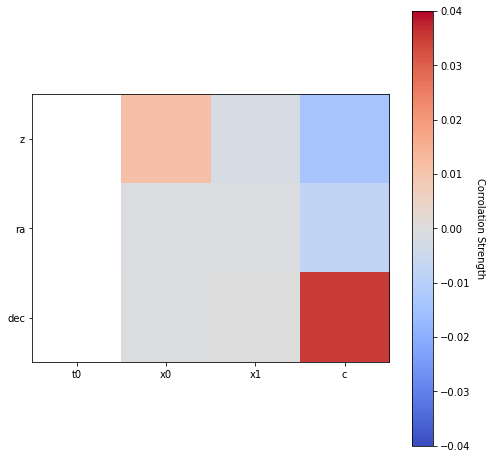

In [16]:
plot_correlations(corr, vmin=-.04, vmax=0.04, label='Corrolation Strength', cmap='coolwarm')
corr


,t0,x0,x1,c
z,NaN,7.246946e-82,0.000189,4.107470e-126
ra,NaN,1.626888e-01,0.272394,1.484702e-40
dec,NaN,3.299937e-01,0.703149,0.000000e+00


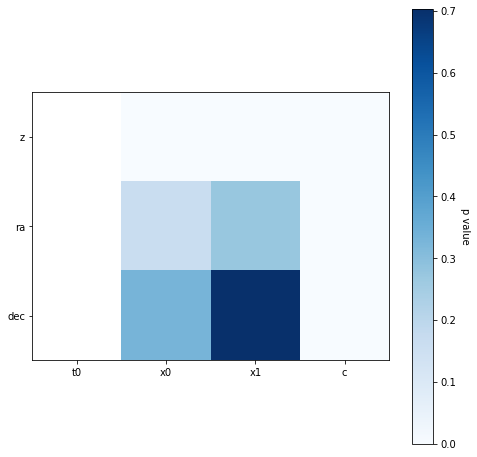

In [17]:
plot_correlations(p, label='p value', cmap='Blues')
p
